In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


### 1. Match the following characteristics of this dataset: 
- total number of actions
- number of unique users
- sizes of the control and experiment groups (i.e., the number of unique users in each group)

In [3]:
# total number of actions
df.shape[0]

8188

In [18]:
# number of unique users
df_uniq = df.drop_duplicates(subset='id')
df_uniq.shape[0]

6328

In [20]:
# size of control group and experiment group
control = df_uniq[df_uniq.group == 'control']
experiment = df_uniq[df_uniq.group == 'experiment']
control.shape[0], experiment.shape[0]

(3332, 2996)

### 2. How long was the experiment run for? 
Hint: the records in this dataset are ordered by timestamp in increasing order

In [31]:
# duration of this experiment
df_uniq.timestamp.min(), df_uniq.timestamp.max()

('2016-09-24 17:42:27.839496', '2017-01-18 10:24:08.629327')

### 3. What action types are recorded in this dataset?
(i.e., What are the unique values in the action column?)

In [30]:
df.action.unique()

array(['view', 'click'], dtype=object)

### 4. Why would we use click through rate instead of number of clicks to compare the performances of control and experiment pages?

AS páginas de controle e de teste podem ter numeros diferentes do total de visitantes. Mais cliques totais podem ocorrer em uma versão, mesmo se houver uma porcentagem muito maior de cliques em outra versão. Obter a proporção de usuários que clicam é mais eficaz do que obter número de usuários que clicam quando comparamos grupos de diferentes tamanhos.

### 5. Define the click through rate (CTR) for this experiment.

Numero de visitantes unicos que clicam pelo menos uma vez dividido pelo numero de visitantes unicos que visualizam a pagina

### 6. What are the null and alternative hypotheses?
Use $CTR_{old}$ and $CTR_{new}$ in your hypotheses.

$$H_0: CTR_{new} - CTR_{old} <= 0$$
$$H_1: CTR_{new} - CTR_{old} > 0$$

In [44]:
#click-through rate for control users
control_df = df.query('group == "control"')
control_ctr = control_df.query('action == "click"').id.nunique() /  control_df.query('action == "view"').id.nunique()
control_ctr

0.2797118847539016

In [46]:
#click-through rate for experiment users
experiment_df = df.query('group == "experiment"')
experiment_ctr = experiment_df.query('action == "click"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
experiment_ctr

0.3097463284379172

In [49]:
# Experiment group's ctr was higher than the control by about 3 %
obs_diff = experiment_ctr - control_ctr
obs_diff

0.030034443684015644

In [51]:
# We have to see if this difference is significant and not just due to chance
# Let's bootstrap the sample to simulate the sampling distribution for the difference in proportions
diffs = []
for _ in range(10000):
    b_samp = df.sample(df.shape[0], replace=True) # Use all the sample but replacing
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df.query('action == "click"').id.nunique() / control_df.query(
        'action == "view"').id.nunique()
    experiment_ctr = experiment_df.query('action == "click"').id.nunique() / experiment_df.query(
        'action == "view"').id.nunique()
    diffs.append(experiment_ctr - control_ctr)

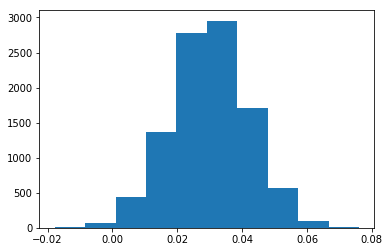

In [57]:
# Take a diffs at our sampling distribution
plt.hist(diffs);

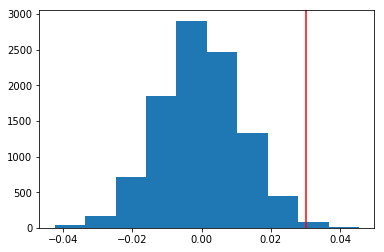

In [59]:
# p-value: The observed difference in proportions by simulating the distribution under the null hypothesis and then
# finding the probability that our statistic came from this distribution
# To simulate from the null, we'll create a normal distribution centered at zero, with the same standard deviation
# as our sampling distribution we simulated here.
diffs = np.array(diffs)
null_vals = np.random.normal(0, diffs.std(), diffs.size)
# See the null distribution
plt.hist(null_vals);
# this is where our observed statistic falls
plt.axvline(x=obs_diff, color='red')

In [61]:
# We can't find p-value like this, as this are all the null values that are more extreme than our statistic
# in favor of our alternative
(null_vals > obs_diff).mean()

0.0049

In [ ]:
# With a p-value of approximately a half of percent (less than 0.01 seems unlikely 
# that our statistic is from tis null), the difference in click-through rates for the control and
# experiment groups does appear to be significant. We can reject the null hypothesis